In [104]:
%matplotlib inline

import os
import datetime
import pytz
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error,r2_score, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

from scipy.sparse import csr_matrix, hstack

TIME_INTERVAL = 5 * 60

In [105]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    ## x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_csv("bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv")
bit_price_d.columns = [x.lower() for x in bit_price_d.columns.values]


bit_price_d = bit_price_d[['timestamp','close']]
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

bit_price_d['date_msc'] = bit_price_d['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
#bit_price_d.head()

##preprbd(bit_price_d)
##bit_price_d.rename(columns={'close':'btc_close'},inplace=True)


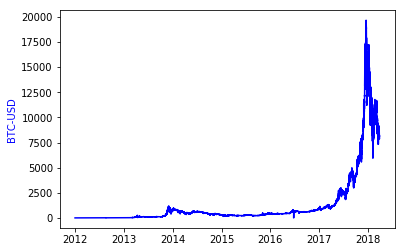

In [106]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date_msc'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


plt.show()

#### Reading news

In [107]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'ninth in terms of BTC/USD ($1536570) trading'

In [108]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])k","\\1 thousands",text)    
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)  ## removing thousands separator
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_bloomberg"
news_corpus = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file, encoding='utf-8', errors='ignore')


    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    news_headline = clean_text(news_headline)
    
    # now time for time
    news_time_str = tt.readline()
    news_time = datetime.datetime.strptime(news_time_str[0:16],"%Y-%m-%dT%H:%M")
    news_time = news_time.replace(tzinfo=pytz.UTC)
    news_timestamp = news_time.timestamp()
    news_date = news_time_str[0:10]
    
    
    # news text and brief
    news_text = "".join(tt.readlines())
    rm = re.search("<content>(.*?)</content>",news_text)
    content = rm.group(0) 
    
    news_text = clean_text(news_text)
    news_corpus.append([news_date, news_timestamp, content,news_headline,news_text])
    
    
print ("text loaded")

news_corpus = pd.DataFrame(news_corpus)
news_corpus.columns = ['date_orig','timestamp_orig','content','headline','text']


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 
              'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')



## Aggregating data on time intervals
##
news_corpus['timestamp_orig'] = news_corpus['timestamp_orig'] - (news_corpus['timestamp_orig'] % TIME_INTERVAL)
# news_corpus['date_full_orig'] = news_corpus['timestamp_orig'].apply(datetime.datetime.fromtimestamp)
news_corpus = news_corpus.query('date_orig>="2017-11-01"')
news_corpus = news_corpus.groupby(['date_orig','timestamp_orig']).apply(compute_metrics)



news_corpus.sort_index(inplace=True)
news_corpus.reset_index(inplace=True)


### prefiltering
###

news_corpus.reset_index(inplace=True)
news_corpus.drop('index',axis=1,inplace=True)


print ("metrics computed")

news_corpus.head()

text loaded
metrics computed
Wall time: 1.86 s


In [109]:
pd.set_option('display.max_colwidth', -1)
aa = news_corpus.sample(1)
print (aa['text'])
pd.set_option('display.max_colwidth', 50)

914      
Name: text, dtype: object


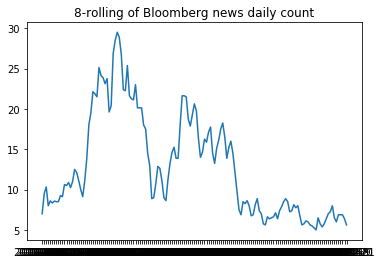

In [110]:
## Plot news count

fig, axs = plt.subplots()

bb_daily = news_corpus.groupby('date_orig')[['count_news']].sum()
bb_daily.reset_index(inplace=True)
bb_daily['date_str']= bb_daily['date_orig'].apply(str)
##bb_daily = bb_daily.query("date_str>='2017-10-01'")
aa = bb_daily.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(bb_daily['date_orig'],aa)
axs.title.set_text("8-rolling of Bloomberg news daily count")



#### Explanation model

In [114]:
%%time

##  Get daily spot price
##

all_data = bit_price_d[['timestamp','btc_close']].copy(deep=True)
all_data = all_data.query("timestamp % (" + str(TIME_INTERVAL)+") == 0")
all_data = all_data.query('timestamp>='+ str(min(news_corpus['timestamp_orig'])-3600))
all_data = all_data.query('timestamp<='+ str(max(news_corpus['timestamp_orig'])+3600))



all_data.sort_values('timestamp',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = np.log(price) - np.log(price_l1)

all_data['btc_dir'] = 0
all_data.loc[all_data['btc_return']<-0.002, 'btc_dir'] = -1
all_data.loc[all_data['btc_return']>0.002, 'btc_dir'] = 1
all_data['btc_dir_l1'] = all_data['btc_dir'].shift(1)

all_data.dropna(inplace=True)


news_corpus['timestamp'] = news_corpus['timestamp_orig'] + TIME_INTERVAL

all_data = all_data.merge(news_corpus[['timestamp','count_news','headline','text']],how='left',on='timestamp')
all_data.fillna('',inplace=True)

filt = [x=='' for x in all_data['count_news']]
all_data.loc[filt,'count_news']=0

## filtering nulls
all_data = all_data.query('count_news>0')
all_data.reset_index(inplace=True)


class LemmaTokenizer():
     def __init__(self):
        self.stm = SnowballStemmer('english')
        self.tkn = RegexpTokenizer(r'\w+')
     def __call__(self, doc):
         return [self.stm.stem(t) for t in self.tkn.tokenize(doc)]
         ##return [self.stm.stem(t) for t in word_tokenize(doc)]

## make headlines
##
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=5, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_headline = tfidf.fit_transform(all_data['headline'])
tfidf_col_names = tfidf.get_feature_names() 
print (tfidif_headline.shape)
print ("headline processed")

tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_text = tfidf.fit_transform(all_data['text'])
tfidf_col_names += tfidf.get_feature_names()
print (tfidif_text.shape)
print ("text processed")


## add column with news counts
tfidif_vectors = hstack([csr_matrix(all_data[['btc_dir_l1']].astype(float)),
                         csr_matrix(all_data[['count_news']].astype(float)),
                         tfidif_headline,tfidif_text],format='csr')
tfidf_col_names = ['btc_dir_l1','#var_count_news'] + tfidf_col_names

##tfidif_vectors = hstack([tfidif_headline,tfidif_text],format='csr')
## tfidif_vectors = tfidif_headline


print (tfidif_vectors.shape)
## tfidif_vectors
all_data

(1659, 549)
headline processed
(1659, 6568)
text processed
(1659, 7119)
Wall time: 10.7 s


In [115]:
all_data.groupby('btc_dir').count()

,index,timestamp,btc_close,btc_return,btc_dir_l1,count_news,headline,text
btc_dir,,,,,,,,
-1,498,498,498,498,498,498,498,498
0,689,689,689,689,689,689,689,689
1,472,472,472,472,472,472,472,472


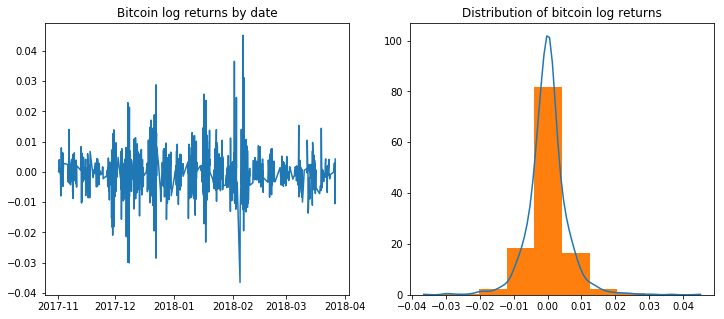

30-percentile -0.00200
70-percentile 0.00183


In [116]:
from scipy.stats.kde import gaussian_kde

fig, (axs1, axs2) = plt.subplots(1,2, figsize=(12,5))


data = all_data['btc_return']
kde = gaussian_kde( data )
dist_space = np.linspace( min(data), max(data), 100 )
# plot the results
axs2.plot( dist_space, kde(dist_space) )
axs2.hist(all_data['btc_return'], density = True)
axs2.set_title("Distribution of bitcoin log returns")

dates = all_data['timestamp'].apply(datetime.datetime.fromtimestamp)
axs1.plot(dates, all_data['btc_return'])
axs1.set_title("Bitcoin log returns by date")

plt.show()

print ('30-percentile %.5f' % np.percentile(data,30) )
print ('70-percentile %.5f' % np.percentile(data,70) )



In [117]:
## split into test and train
##

train_size =0.90
train_ind = int(all_data.shape[0] * train_size)
print (all_data.loc[train_ind,'timestamp'])


matr = tfidif_vectors

## dates_train =all_data.loc[:train_ind,'date']
X_train = matr[:train_ind+1,]
y_train = all_data.loc[:train_ind,'btc_dir']

## dates_test = all_data.loc[train_ind+1:,'date']
X_test = matr[train_ind+1:,]
y_test =  all_data.loc[train_ind+1:,'btc_dir']

1519731300


#### Ridge Model

In [118]:
def model_predict (mm,titles=[""]):
    
    print ("Fitting the model")
    ##mm.fit(X_train,y_train)
    
    y_pred = mm.predict(X_test)    

        ## Plot train data
    try: 
        y_score = mm.decision_function(X_test)
    except:
        y_score = mm.predict_proba(X_test)
        y_score = [x[1] for x in y_score]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)    
    print ("ROC-AUC test: ", roc_auc) 
    
    acc = accuracy_score(y_pred,y_test)
    print ("accuracy: ", acc) 

    
    fig, (axs) = plt.subplots(1,1, figsize=(5,5))
    axs.plot(fpr,tpr,'b', label="ROC_AUC: {0:.02f}".format(roc_auc))
    axs.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs.set_title(titles[0])
    axs.legend()
    plt.show()

In [119]:

def model_kfold_predict (mm, folds_num = 4, titles = ["",""]):
    acc_list = []
    acc_names = []
    
    ## fig, (axs1, axs2) = plt.subplots(1,2, figsize=(15,7))
    ## axs1.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ## axs2.plot([0, 1], [0, 1], color='navy', linestyle='--')

    kf = KFold (n_splits=folds_num,shuffle=False)
    ## tscv = TimeSeriesSplit(n_splits=folds_num)
    print ("Doing TimeSeries validation")    
        
    i = 0 
    for train_index, test_index in kf.split(X_train):
        i=i+1
        print ("Doing fold " + str(i))
        
        X_fold_train, X__fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y__fold_test = y_train[train_index], y_train[test_index]

        mm.fit(X_fold_train, y_fold_train)
        
        y_pred = mm.predict(X__fold_test)
        acc = accuracy_score(y_pred,y__fold_test)
        acc_list.append(acc)
        acc_names.append("fold " + str(i))
        
        ## print (acc)
    print ("KFold Accuracy: ",["{0:.4f}".format(x) for x in acc_list], np.mean(acc_list))

    
    ## Do on test data
    mm.fit(X_train,y_train)
    ## Plot train data
    y_pred = mm.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
    print ("valid acc: %.2f"%acc)
    
    acc_list.append(acc)
    acc_names.append("valid")
    
    
    ## fig, (axs1) = plt.subplots(1,1, figsize=(7,5))
    
    plt.bar(list(range(len(acc_list))),acc_list)
    plt.xticks(list(range(len(acc_list))), acc_names, rotation='vertical')
    plt.ylim([0,max(acc_list)+0.1])
    plt.title(titles[0])
    
    print (acc_list)
    for i, v in enumerate(acc_list):
        
        plt.text(i -0.4, v + 0.01, "{0:.2f}".format(v))
    plt.show()
    print ("av hit rate %.3f" % np.mean(acc_list))

Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold Accuracy:  ['0.3333', '0.4467', '0.3933', '0.3467', '0.3087', '0.3087', '0.2886', '0.3423', '0.3557', '0.3557'] 0.347973154362
valid acc: 0.38
[0.33333333333333331, 0.44666666666666666, 0.39333333333333331, 0.34666666666666668, 0.3087248322147651, 0.3087248322147651, 0.28859060402684567, 0.34228187919463088, 0.35570469798657717, 0.35570469798657717, 0.38181818181818183]


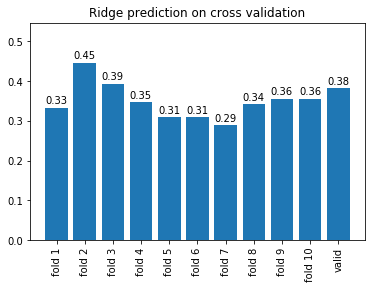

av hit rate 0.351


In [120]:
rdg = RidgeClassifier(alpha=1, fit_intercept=True, normalize=False)
model_kfold_predict(rdg,folds_num=10, titles=["Ridge prediction on cross validation","Ridge prediction on Validation"])

In [126]:
a1 = [0.33,0.45,0.39,0.35,0.31,0.31,0.29,0.34,0.36,0.36,0.38]
print (np.mean(a1), np.std(a1))

0.351818181818 0.0426013618686


#### Extra Trees

In [ ]:
ExtraTreesClassifier??

In [127]:
%%time
kf = KFold (n_splits=10,shuffle=False)
tscv = TimeSeriesSplit(n_splits=10)

for i_tree in np.arange(10,500,10):
#for i_spl in np.arange(2,10,1):    
    etr = ExtraTreesClassifier(n_estimators=i_tree, criterion='gini', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=8, 
                               n_jobs = -1, random_state=14)

    scores = cross_val_score(etr, X_train, y_train,cv=kf,scoring ='accuracy')
    print (i_tree, np.mean(scores), np.std(scores), scores)

10 0.366684563758 0.0567523918126 [ 0.37333333  0.45333333  0.40666667  0.40666667  0.40939597  0.34899329
  0.23489933  0.33557047  0.33557047  0.36241611]
20 0.368004474273 0.0605237710834 [ 0.43333333  0.45333333  0.36666667  0.42        0.42281879  0.32885906
  0.25503356  0.30201342  0.34899329  0.34899329]
30 0.367995525727 0.0704668386154 [ 0.42        0.46666667  0.35333333  0.44666667  0.44966443  0.33557047
  0.24161074  0.30201342  0.32214765  0.34228188]
40 0.369982102908 0.0728060654797 [ 0.41333333  0.48        0.4         0.43333333  0.44966443  0.34228188
  0.24161074  0.29530201  0.30872483  0.33557047]
50 0.377364653244 0.0640031956284 [ 0.42666667  0.46666667  0.40666667  0.42666667  0.4295302   0.3557047
  0.24161074  0.31543624  0.33557047  0.36912752]
60 0.376026845638 0.0610352126138 [ 0.42666667  0.46        0.40666667  0.42666667  0.41610738  0.34228188
  0.24161074  0.33557047  0.33557047  0.36912752]
70 0.377355704698 0.0638441636625 [ 0.42666667  0.48666667 

KeyboardInterrupt: 

In [85]:
%%time
etr  = ExtraTreesClassifier(n_estimators=10, criterion='gini', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=6, n_jobs = -1, 
                           random_state=14)
etr.fit(X_train,y_train)

Wall time: 119 ms


Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold Accuracy:  ['0.4060', '0.4060', '0.4286', '0.3106', '0.3333', '0.2803', '0.3030', '0.3864', '0.3333', '0.3788'] 0.356635907952
valid acc: 0.38
[0.40601503759398494, 0.40601503759398494, 0.42857142857142855, 0.31060606060606061, 0.33333333333333331, 0.28030303030303028, 0.30303030303030304, 0.38636363636363635, 0.33333333333333331, 0.37878787878787878, 0.37671232876712329]


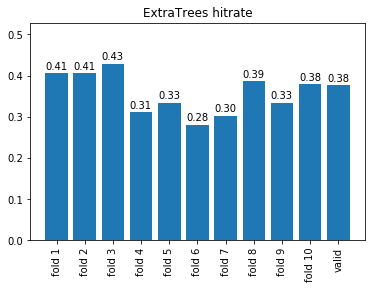

av hit rate 0.358


In [86]:
## model_kfold_predict(etr)
model_kfold_predict(etr,folds_num=10, titles=["ExtraTrees hitrate"])

In [ ]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


### LGBM

In [88]:
import lightgbm as lgb


In [89]:
lgb_train = lgb.Dataset(X_train, y_train+1)
lgb_eval = lgb.Dataset(X_test, y_test+1, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': {'multi_logloss','auc'},
    'num_leaves': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Start training...
[1]	valid_0's auc: 0.529717	valid_0's multi_logloss: 1.09817
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.545165	valid_0's multi_logloss: 1.0983
[3]	valid_0's auc: 0.578302	valid_0's multi_logloss: 1.09796
[4]	valid_0's auc: 0.572406	valid_0's multi_logloss: 1.0969
[5]	valid_0's auc: 0.57842	valid_0's multi_logloss: 1.09559
[6]	valid_0's auc: 0.566274	valid_0's multi_logloss: 1.09523
[7]	valid_0's auc: 0.571462	valid_0's multi_logloss: 1.09482
[8]	valid_0's auc: 0.562972	valid_0's multi_logloss: 1.0938
[9]	valid_0's auc: 0.552241	valid_0's multi_logloss: 1.09182
[10]	valid_0's auc: 0.559198	valid_0's multi_logloss: 1.0917
Early stopping, best iteration is:
[5]	valid_0's auc: 0.57842	valid_0's multi_logloss: 1.09559


In [90]:
y_pred = gbm.predict(X_test)
y_pred = np.array([np.argmax(x) for x in y_pred]) -1
accuracy_score(y_test, y_pred)

0.41095890410958902

In [ ]:
lgb.train(params,lgb_train)

In [91]:
params = {

    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': {'multi_logloss','multi_error'},
    'num_leaves': 10,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': 1
}

lgb.cv(params,
        lgb_train,
       num_boost_round=500,
        nfold = 10,
        early_stopping_rounds=25,
       shuffle= False,
       stratified = False
      )


{'multi_error-mean': [0.64090909090909087,
  0.64772727272727271,
  0.64015151515151525,
  0.634848484848485,
  0.63560606060606062,
  0.63484848484848488,
  0.63484848484848477],
 'multi_error-stdv': [0.031455362866707116,
  0.044335984510301615,
  0.041666666666666671,
  0.040768557718405173,
  0.030388138060805429,
  0.035339102393001823,
  0.034015067152490371],
 'multi_logloss-mean': [1.0986168447103224,
  1.0986063554644698,
  1.0986023473527755,
  1.0985966630169854,
  1.0985863196208576,
  1.0985756260713373,
  1.0985833805369514],
 'multi_logloss-stdv': [1.3755509680133872e-05,
  3.1834455402702494e-05,
  4.5953368857961013e-05,
  6.0228205522315346e-05,
  7.5335767325073838e-05,
  8.9430870734481143e-05,
  9.1584985152385283e-05]}

In [ ]:
lgb.cv??

### summary graph


[0.378, 0.389, 0.367, 0.353, 0.358]


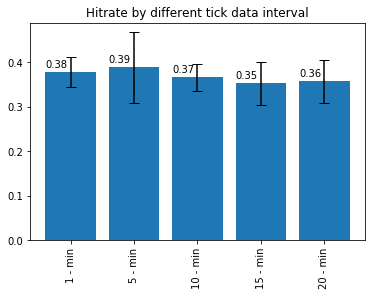

Std errors:  [0.0335, 0.07969, 0.03053, 0.04772, 0.04851]


In [132]:
acc_names = ['1 - min','5 - min','10 - min','15 - min','20 - min']
acc_list = [0.378, 0.389, 0.367, 0.353, 0.358]
std_list = [0.0335,0.07969,0.03053, 0.04772, 0.04851]

plt.bar(list(range(len(acc_list))),acc_list,yerr=std_list,capsize=5)
plt.xticks(list(range(len(acc_list))), acc_names, rotation='vertical')
plt.ylim([0,max(acc_list)+0.1])
plt.title('Hitrate by different tick data interval')

print (acc_list)
for i, v in enumerate(acc_list):

    plt.text(i -0.4, v + 0.01, "{0:.2f}".format(v))
plt.show()
print ("Std errors: ", std_list)

In [98]:
a1 = [0.33,0.38,0.37,0.40,0.36,0.31,0.41,0.37,0.42,0.42,0.38]
a2 = [0.47,0.49,0.41,0.43,0.44,0.34,0.25,0.35,0.35,0.37,0.55]
a3 = [0.38,0.41,0.36,0.36,0.34,0.34,0.32,0.36,0.38,0.35,0.43]
a4 = [0.39,0.33,0.39,0.38,0.32,0.31,0.29,0.33,0.30,0.41,0.44]
a5 = [0.41,0.41,0.43,0.31,0.33,0.28,0.30,0.39,0.33,0.38,0.38]

In [97]:
np.std([1,2])

0.5

In [103]:
np.std(a5)

0.048515142051368483